In [1]:
%pip install --quiet --upgrade flwr==1.5.0
%pip install --quiet --upgrade tensorflow
%pip install --quiet --upgrade tensorflow-cpu
%pip install --quiet --upgrade tensorflow-cpu==2.14.1
%pip install --quiet --upgrade scikit-learn
%pip install --quiet --upgrade pandas
%pip install --quiet --upgrade matplotlib
%pip install --quiet --upgrade git+https://github.com/nepiskopos/py7zr.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow-cpu (from versions: none)
ERROR: No matching distribution found for tensorflow-cpu
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow-cpu==2.14.1 (from versions: none)
ERROR: No matching distribution found for tensorflow-cpu==2.14.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import errno
import os
import py7zr
import re
import shutil
import sys
import time
import urllib


def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()

def download(url, filename):
    urllib.request.urlretrieve(url, filename, reporthook)

def extract(archive, target_dir):
    archive = py7zr.SevenZipFile(archive, mode='r')
    try:
        os.makedirs(target_dir)
        
        archive.extractall(path=target_dir)
        archive.close()
        
        print(f"Archive '{archive}' extracted successfully!")
    except OSError as e:
        if e.errno == errno.EEXIST:
            archive.extractall(path=target_dir)
            archive.close()
            
            print(f"Archive '{archive}' extracted successfully!")
        else:
            print(f"Archive '{archive}' failed to extract...")


base_data_dir = './datasets'

if not os.path.isdir(os.path.join(base_data_dir, 'Balanced_IEC104_Train_Test_CSV_Files')):
    filename = 'Balanced_IEC104_Train_Test_CSV_Files.7z'
    
    if not py7zr.is_7zfile(filename):
        url = ('https://zenodo.org/records/7108614/files/Balanced_IEC104_Train_Test_CSV_Files.7z?download=1')
        download(url, filename)
    
    extract(filename, base_data_dir)

    innerDirs = os.listdir(base_data_dir)
    for dir in innerDirs:
        if (re.search('2020*', dir)):
            shutil.rmtree(os.path.join(base_data_dir, dir))
    
    os.remove(os.path.join('.', filename))

In [3]:
import collections
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

pd.set_option('future.no_silent_downcasting', True)

%matplotlib inline

In [4]:
tp = 'cic'      # Type: dataset type (CICFlowMeter or Custom Python parser), choose between 'cic' and 'custom'
#tm = 180        # Timeout: data flow timeout, choose a value from the following list [15, 30, 60, 90, 120, 180]
n_workers = 3   # N: number of federated workers, choose between 3 and 5

In [5]:
assert tp in ('cic', 'custom'), "Wrong dataset type, choose between 'cic' and 'custom'"
#assert tm in (15, 30, 60, 90, 120, 180), "Wrong time, choose a value from the following list [15, 30, 60, 90, 120, 180]"
assert n_workers in (3, 4, 5), "Wrong number of workers, choose between 3 and 5"

In [6]:
path = os.path.join(base_data_dir, 'Balanced_IEC104_Train_Test_CSV_Files/iec104_train_test_csvs')
dataset = f'tests_{tp}_{tm}'

if 'cic' in dataset:
    n = dataset.split('_')[-1]
    train_csv = os.path.join(os.path.join(path, dataset), f'train_{tm}_cicflow.csv')
    test_csv = os.path.join(os.path.join(path, dataset), f'test_{tm}_cicflow.csv')
elif 'custom' in dataset:
    n = dataset.split('_')
    train_csv = os.path.join(os.path.join(path, dataset), f'train_{tm}_custom_script.csv')
    test_csv = os.path.join(os.path.join(path, dataset), f'test_{tm}_custom_script.csv')
else:
    raise Exception("Wrong dataset")

df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(train_csv)

NameError: name 'tm' is not defined

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            3588 non-null   object 
 1   Src IP             3588 non-null   object 
 2   Src Port           3588 non-null   int64  
 3   Dst IP             3588 non-null   object 
 4   Dst Port           3588 non-null   int64  
 5   Protocol           3588 non-null   int64  
 6   Timestamp          3588 non-null   object 
 7   Flow Duration      3588 non-null   int64  
 8   Tot Fwd Pkts       3588 non-null   int64  
 9   Tot Bwd Pkts       3588 non-null   int64  
 10  TotLen Fwd Pkts    3588 non-null   int64  
 11  TotLen Bwd Pkts    3588 non-null   int64  
 12  Fwd Pkt Len Max    3588 non-null   int64  
 13  Fwd Pkt Len Min    3588 non-null   int64  
 14  Fwd Pkt Len Mean   3588 non-null   float64
 15  Fwd Pkt Len Std    3588 non-null   float64
 16  Bwd Pkt Len Max    3588 

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            3588 non-null   object 
 1   Src IP             3588 non-null   object 
 2   Src Port           3588 non-null   int64  
 3   Dst IP             3588 non-null   object 
 4   Dst Port           3588 non-null   int64  
 5   Protocol           3588 non-null   int64  
 6   Timestamp          3588 non-null   object 
 7   Flow Duration      3588 non-null   int64  
 8   Tot Fwd Pkts       3588 non-null   int64  
 9   Tot Bwd Pkts       3588 non-null   int64  
 10  TotLen Fwd Pkts    3588 non-null   int64  
 11  TotLen Bwd Pkts    3588 non-null   int64  
 12  Fwd Pkt Len Max    3588 non-null   int64  
 13  Fwd Pkt Len Min    3588 non-null   int64  
 14  Fwd Pkt Len Mean   3588 non-null   float64
 15  Fwd Pkt Len Std    3588 non-null   float64
 16  Bwd Pkt Len Max    3588 

In [ ]:
df_train['Label'] = df_train['Label'].str.lower()
df_test['Label'] = df_test['Label'].str.lower()

unique_labels = list(df_train.Label.astype('category').unique())
unique_codes = list(df_train.Label.astype('category').cat.codes.unique())

mapping = dict(zip(unique_labels, unique_codes))
mapping_inv = dict(zip(unique_codes, unique_labels))

In [ ]:
mapping

{'normal': 11,
 'c_ci_na_1': 0,
 'c_ci_na_1_dos': 1,
 'c_rd_na_1': 2,
 'c_rd_na_1_dos': 3,
 'c_rp_na_1': 4,
 'c_rp_na_1_dos': 5,
 'c_sc_na_1': 6,
 'c_sc_na_1_dos': 7,
 'c_se_na_1': 8,
 'c_se_na_1_dos': 9,
 'm_sp_na_1_dos': 10}

In [ ]:
df_train['Label'] = df_train['Label'].astype('category').cat.rename_categories(mapping)
df_test['Label'] = df_test['Label'].astype('category').cat.rename_categories(mapping)

In [ ]:
if tp == 'cic':
    train = df_train.iloc[:,7:]
    test = df_test.iloc[:,7:]
else:
    train = df_train
    test = df_test

In [ ]:
train.rename(columns={"Label": "y"}, inplace=True, errors="raise")
test.rename(columns={"Label": "y"}, inplace=True, errors="raise")

In [ ]:
# Replace Inf values with NaN
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
train.dropna(inplace=True)
test.dropna(inplace=True)

In [ ]:
directory = os.path.join(base_data_dir, 'federated_datasets')

try:
    os.makedirs(directory)
    train.to_csv(os.path.join(directory, 'train_data.csv'), index=False)
    test.to_csv(os.path.join(directory, 'test_data.csv'), index=False)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    else:   
        train.to_csv(os.path.join(directory, 'train_data.csv'), index=False)
        test.to_csv(os.path.join(directory, 'test_data.csv'), index=False)

In [ ]:
n_samples = int(train.shape[0] / n_workers)

assert type(n_workers) == int, "Non-int number of workers"
assert n_workers >= 3 and n_workers <= df_train.shape[0], "At least 3 workers and at most as many workers as the number of samples are allowed"
assert n_samples > 0, "Each worker must be assigned at least one data point"

In [ ]:
client_data = []
train_copy = train.copy()

for i in range(n_workers):
    sample = train_copy.sample(n=n_samples)
    sample.to_csv(os.path.join(directory, f'client_train_data_{i+1}.csv'), index=False)
    train_copy.drop(index=sample.index, inplace=True)
    client_data.append(sample)

In [ ]:
for i in range(n_workers):
    print(f"Worker {i+1} training data contains {len(client_data[i])} points")

Worker 1 training data contains 1196 points
Worker 2 training data contains 1196 points
Worker 3 training data contains 1196 points


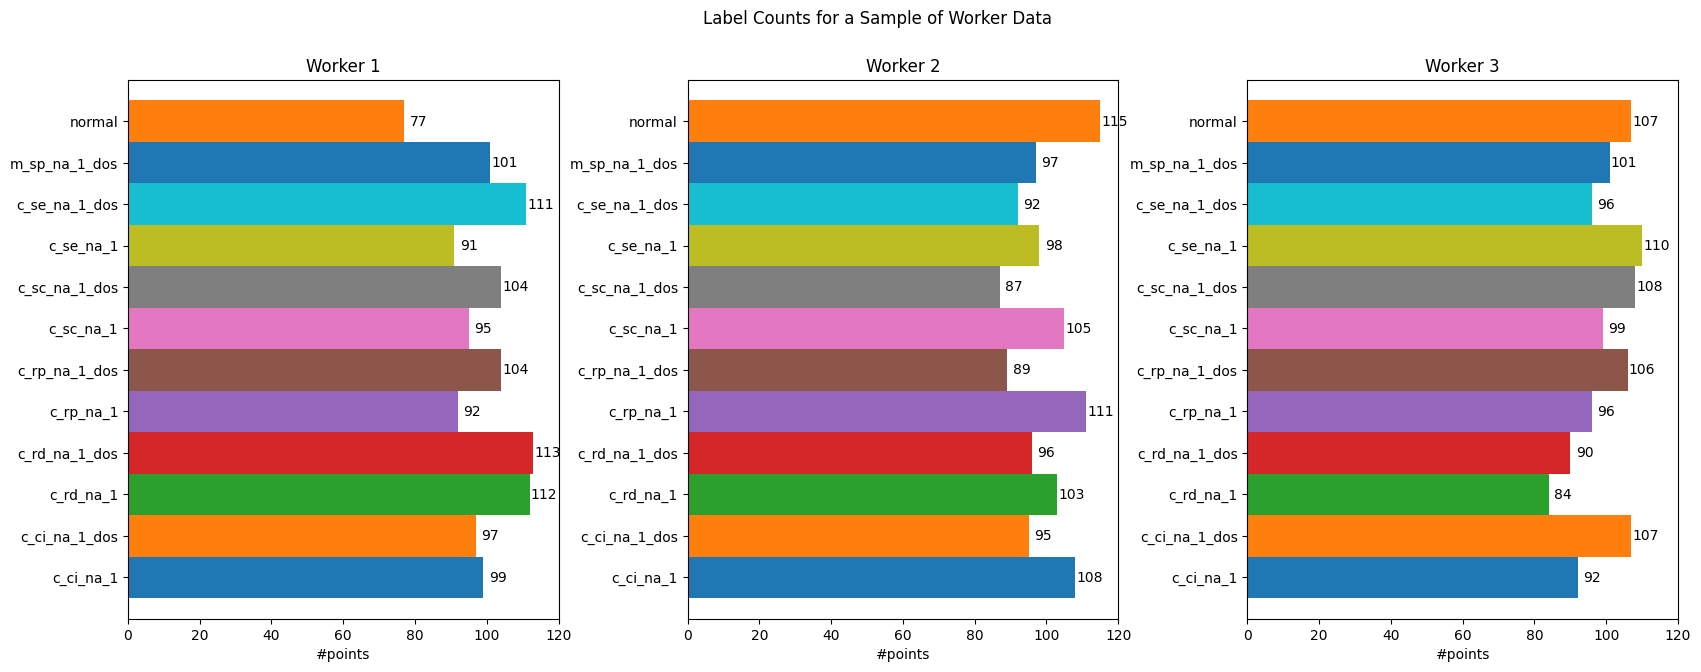

In [ ]:
# Number of examples per layer for a sample of clients
fig = plt.figure(figsize=(20, 7))
fig.suptitle('Label Counts for a Sample of Worker Data')
fig.tight_layout()

for i in range(n_workers):
    m = 0
    plot_data = collections.defaultdict(list)
    sample = client_data[i]
    for label in sample['y']:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        plot_data[label].append(label)
        m = max(m, len(plot_data[label]))
    
    n_cols = n_workers if n_workers < 5 else 5
    xlim = [0, m+(20-m%20)]
    ylim = [min(unique_codes)-1, max(unique_codes)+1]
    yticks = list(range(min(unique_codes), max(unique_codes)+1))
    yticks_labels = [mapping_inv[k] for k in range(0, max(unique_codes)+1)]
    
    plt.subplot(int(n_workers / 5)+1, n_cols, i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Worker {}'.format(i+1))
    plt.xlabel('#points')
    plt.xlim(xlim)
    # plt.ylabel('Label')
    plt.ylim(ylim)
    plt.yticks(yticks, labels=yticks_labels)
    
    # plot values on top of bars
    for key in plot_data:
        if len(plot_data[key]) > 0:
            plt.text(len(plot_data[key])+4, int(key)-0.1, str(len(plot_data[key])), ha='center')
    
    for j in range(min(unique_codes),max(unique_codes)+1):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[k-0.5 for k in range(min(unique_codes),max(unique_codes)+2)],
            orientation='horizontal'
        )

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train = scaler.fit_transform(train.drop(['y'], axis=1).to_numpy())
y_train = train['y'].to_numpy()
X_test = scaler.transform(test.drop(['y'], axis=1).to_numpy())
y_test = test['y'].to_numpy()

In [ ]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=y_train_cat.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
model.fit(
    x=X_train, 
    y=y_train_cat, 
    epochs=300,
    validation_data=(X_test, y_test_cat),
    verbose=1,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/300


In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss[['loss','val_loss']].plot()

In [ ]:
print("Loss, Accuracy: ", model.evaluate(X_test, y_test_cat))

In [ ]:
print("F1-score: ", f1_score(y_test, np.argmax(model.predict(X_test), axis=1), average='weighted'))